<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import operator
import matplotlib
import statsmodels.tools.eval_measures as bias
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from mpl_toolkits.mplot3d import Axes3D # Axes3D import has side effects, it enables using projection='3d' in add_subplot
from math import ceil
from scipy import linalg
from os import listdir
from numpy.random import uniform, normal
from numpy.linalg import *
from scipy.stats.stats import pearsonr
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg

In [48]:
def dibuja_hist(df,colour,name,Xlabel,Ylabel,title):
    plt.figure()
    df.hist(column=0, bins=25, grid=False, figsize=(6,3), color=colour, zorder=2, rwidth=0.9)
    plt.xticks(rotation=90)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    #https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors/42020486
    mytitle = plt.title(title) # get the title property handler   #plt.getp(title_obj)  
    plt.setp(mytitle, color='#ff8000')                            # set the color of title
    myax = plt.axes()   # get the axis property handler           # plt.getp(myax) print its propieties
    myax.xaxis.label.set_color('#ff8000')
    myax.yaxis.label.set_color('#ff8000')
    myax.tick_params(colors='#ff8000', which='both')              # myax.spines['bottom'].set_color('yellow')
    plt.savefig(name, transparent=True)
    plt.show()                                                    # o plt.save_en_algún_formato()

# Tarea 7: **Cross-validation** Y **Bootstrap** en validación de modelos de regresión local en predicción de demanda eléctrica.

> Instructions: Apply both cross-validation and bootstrap to your project data to study how variable your results are when you switch the test set around.`

En esta tarea haremos validación y pruebas al modelo planteado en la tarea 6 de regresión local (lineal) para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$.

La implementación fue realizada basada en las consideraciones del libro [The Elements of Statistical Learning](https://link.springer.com/book/10.1007/978-0-387-84858-7) secciones; 7.11 Bootstrap Methods y 7.10 Cross-Validation.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

Iniciamos calcuando los pesos de los puntos $x_i\in\mathcal{Rp}$ del vecindario alrededor del punto $x_o\in\mathcal{Rp}$.

Damos mayor peso a las puntos $x_i$ mas cercanos al punto $x_o$ y menos peso a las observaciones más lejanas. 
Calcularemos los pesos de los puntos utilizando un kernel que asigna importancia a cada uno de los k vecinos de $x_i$ según su distancia a $x_o$.

In [49]:
# Calcula los pesos y regresa una matriz diagonal con los pesos
def get_weight_exp(xo, X, k): 
## k    : tamanio del vecindario (bandwidth)
## X    : Regresores
## xo   : punto donde se desea hacer la predicción.

    n = X.shape[0]             ## numero de datos
    weight = np.mat(np.eye(n)) ## Matriz de pesos identidad W.
    
  # Cálculo de pesos para todos los datos de entrenamiento xi.
    for i in range(n): 
        xi = X[i] 
        d = (-2 * k * k) 
        weight[i, i] = np.exp(np.dot((xi-xo), (xi-xo).T)/d) 
        
    return weight

A continuación estimamos los coeficientes de regresión `β = (Xt W(xo) X)^{-1}) (Xt W Y)` con la matrix de pesos `W`.

In [50]:
def local_regression(X,W,Xo):
    # W     --> Matriz diagonal de pesos
    # X     --> Regresores
    # xo    --> punto donde se desea hacer la predicción.
    Xt = X.T  # Calcula transpuesta de X
    A = np.matmul(Xt, np.matmul(W,X)) 
    A = np.linalg.inv(A)   # Calcula inversa de A
    B = np.matmul(Xt, np.matmul(W,Y)) 
    beta = np.matmul(A,B)
    prediccion = np.matmul(Xo,beta)
    return prediccion

## Regresión local en $\mathcal{Rp}$ en predicción de demanda eléctrica

A continuación haremos la comparación de resultados de regresión para datos de demanda eléctrica. La variable independiente $X$ serán los datos de demanda del día anterior, y los datos independiente $Y$ serán los datos de días con una mayor correlación con $X$. En esta sección, aplicaremos técnicas de regresión local con multiples regresores X.

Los datos usados en esta sección están disponibles en [demanda.csv](https://drive.google.com/file/d/1KpY2p4bfVEwGRh5tJjMx9QpH6SEwrUwH/view?usp=sharing)

In [51]:
df    = pd.read_csv('demanda.csv')
#df.std(numeric_only = True) 
#df.mean(numeric_only = True)
#df = df - df.mean(numeric_only = True)
#df = df / df.std(numeric_only = True)
X   = pd.DataFrame(df[['X1','X2']]).to_numpy()
Y   = pd.DataFrame(df[['Y']]).to_numpy()
#X = X + uniform()

En esta función se recorre uno a uno los puntos de la función de `X_test` para calcular la predicción. Es decir, para cada uno de los datos, seleccionaremos una vecindad de k puntos muestreados y los usaremos como conjunto de entrenamiento para un problema de regresión lineal con pesos. Aunque ajustamos un modelo lineal completo a los datos de la vecindad, solamente lo usamos para evaluar el ajuste en el único punto `xo`. 

In [52]:
k = 0 # Tamanio del vecindario
kmin = 10
kmax = 25
rep_list= []
Y_local_list= []
aux = 0

for rep in range(1000):
    Y_local = []
    a = np.sort(np.arange(0,X.shape[0]))
    b = np.sort(np.random.choice(a, replace=False, size = int(len(a)*0.5)))
    c = np.sort(np.setdiff1d(a, b))
    X_train = np.delete(X, b, axis = 0)
    #X_test  = np.delete(X, c, axis = 0)
    Y_train = np.delete(Y, b, axis = 0)
    #Y_test  = np.delete(Y, c, axis = 0)
    #for i in range(X_train.shape[0]):   #para local punto por punto
    for i in range(1):
        k = kmin
        flag = True
        while( flag == True ):
            try:
                #xo = X_train[[i]]
                #W = get_weight_exp(xo, X_train, k)
                #pred = local_regression(X_test, W, xo)
                #Y_local.append(pred.item(0))

                Y_pred = []
                olsmod = sm.OLS(Y_train, X_train)
                olsres = olsmod.fit()
                Y_pred = olsres.predict(X_train)
                #Y_local.append(Y_pred)

            except:
                print("Sorry! Singular matrix found in position i=",str(i),"k=", k)
                k = k + 1
                if(k>kmax):                
                    flag = False
                    Y_local.append(0)
            else:
                flag = False
    
    rep_list.append(mean_absolute_error(Y_train,Y_pred))
Y_local_list.append(rep_list)
print(Y_local_list)

[[134.65412807263692, 155.69087214582677, 138.13944824330684, 140.1293954848783, 143.4686239789991, 139.0309754178608, 139.5332185606201, 140.4189507476262, 138.91625722951318, 135.6862256170608, 137.80085309803883, 137.03573382048162, 143.96598735883572, 133.7546151219518, 138.21445972270874, 138.07872192308798, 132.37813367397808, 135.94307680227524, 142.2022586298436, 138.2506181484577, 132.46514717469867, 142.46281912516991, 140.2388228695456, 135.91521209738812, 130.2185997063171, 131.9078838596139, 137.46466690374473, 135.63100788103995, 129.15096966470688, 129.9642858999104, 138.1023847077526, 137.57909147456172, 133.67100299748458, 142.13336383760708, 134.25799686158578, 133.97979719207513, 135.06988545340653, 145.1272667407604, 134.49251234891858, 141.70633753053374, 144.94189555866805, 137.07596909025582, 151.91679252813324, 144.1632873555535, 138.29298892051668, 143.40220409613863, 133.91648665480741, 146.35914461388165, 143.6807199975004, 132.07284219191382, 147.60024354658

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


<Figure size 432x288 with 0 Axes>

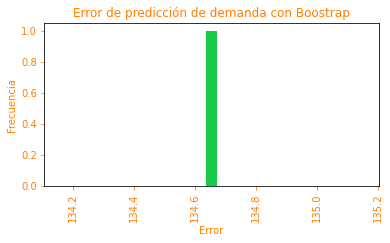

In [53]:
df = pd.DataFrame(Y_local_list)
dibuja_hist(df,colour='#17cb49',name='hist_t7_1.png',Xlabel="Error",Ylabel="Frecuencia",title="Error de predicción de demanda con Boostrap")

Variamos los tamaños de las vecindades

In [54]:
k = 0 # Tamanio del vecindario
klist = [25,35,50,100]
aux=0
for item in klist:
    k = item
    Y_local = []
    for i in range(X.shape[0]):
        try:
            xo = X[[i]]
            W = get_weight_exp(xo, X, k)
            Ygorro = local_regression(X, W, xo)
            Y_local.append(Ygorro.item(0))
            aux = Ygorro.item(0)
        except:
            Y_local.append(aux)
            print("Sorry! Singular matrix found in position i=",str(i))
    Y_local_list.append(mean_absolute_error(Y,Y_local[0]))

TypeError: ignored

En esta sección calculamos la predicción usando unicamente la regresión lineal múltiple. Como se observa en este caso los pesos `W` son la matriz identidad.

In [ ]:
Y_pred = []
for i in range(X.shape[0]):
    xo = X[[i]]
    W = np.mat(np.eye(X.shape[0])) 
    Ygorro = local_regression(X, W, xo)
    Y_pred.append(Ygorro.item(0))

Calculamos los errores de los métodos de regresión comparados, variando además los tamaños de las vecindades `k`.

In [ ]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [ ]:
mae_pred  = trunc(mean_absolute_error(Y,Y_pred),4)
mae_local_k0 = trunc(mean_absolute_error(Y,Y_local_list[0]),4)
mae_local_k1 = trunc(mean_absolute_error(Y,Y_local_list[1]),4)
mae_local_k2 = trunc(mean_absolute_error(Y,Y_local_list[2]),4)
mae_local_k3 = trunc(mean_absolute_error(Y,Y_local_list[3]),4)
mae_local_k4 = trunc(mean_absolute_error(Y,Y_local_list[4]),4)

In [ ]:
mse_pred  = trunc(mean_squared_error(Y,Y_pred),4)
mse_local_k0 = trunc(mean_squared_error(Y,Y_local_list[0]),4)
mse_local_k1 = trunc(mean_squared_error(Y,Y_local_list[1]),4)
mse_local_k2 = trunc(mean_squared_error(Y,Y_local_list[2]),4)
mse_local_k3 = trunc(mean_squared_error(Y,Y_local_list[3]),4)
mse_local_k4 = trunc(mean_squared_error(Y,Y_local_list[4]),4)

In [ ]:
mape_pred  = trunc(mean_absolute_percentage_error(Y,Y_pred),4)
mape_local_k0 = trunc(mean_absolute_percentage_error(Y,Y_local_list[0]),4)
mape_local_k1 = trunc(mean_absolute_percentage_error(Y,Y_local_list[1]),4)
mape_local_k2 = trunc(mean_absolute_percentage_error(Y,Y_local_list[2]),4)
mape_local_k3 = trunc(mean_absolute_percentage_error(Y,Y_local_list[3]),4)
mape_local_k4 = trunc(mean_absolute_percentage_error(Y,Y_local_list[4]),4)

print('| REGRESIÓN      | MAE            | MSD            | MAPE         |')
print('| :------------- | -------------: | -------------: |-------------:|')
print('| local, k=10 |',str(mae_local_k0),'   |',str(mse_local_k0),'   |   ',str(mape_local_k0),'|')
print('| local, k=25 |',str(mae_local_k1),'   |',str(mse_local_k1),'   |   ',str(mape_local_k1),'|')
print('| local, k=35 |',str(mae_local_k2),'   |',str(mse_local_k2),'   |   ',str(mape_local_k2),'|')
print('| local, k=50 |',str(mae_local_k3),'   |',str(mse_local_k3),'   |   ',str(mape_local_k3),'|')
print('| local, k=100|',str(mae_local_k4),'   |',str(mse_local_k4),'   |   ',str(mape_local_k4),'|')
print('|    lineal      |',str(mae_pred),'    |',str(mse_pred),'   |   ',str(mape_pred),'|')

Graficamos los resultados de predicción de la regresión local con k= [10,25,35,50] y regresión local para pronosticar los datos de prueba `Y`.

In [ ]:
fig  = plt.figure(figsize=(16,9))
axes = fig.add_subplot(1, 1, 1)
#plt.style.use("seaborn-poster")
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; AZUL='#168fff';
mytitle = plt.title('Regresión lineal local en pronóstico de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA)                                        #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(Y) )
plt.scatter( AUX,Y,s=25,marker='o' , color = 'red'      , label = 'Y'              ,alpha=1/2)
axes.plot  ( Y_local_list[0], '.-' , color = LETRASNARA , label = 'Y_local,k>=10'   ,alpha=1/2)
axes.plot  ( Y_local_list[1], '.-' , color = VERDE      , label = 'Y_local,k=25'   ,alpha=1/2)
axes.plot  ( Y_local_list[2], '.-' , color = AZUL       , label = 'Y_local,k=35'   ,alpha=1/2)
axes.plot  ( Y_local_list[3], '.-' , color = LILA       , label = 'Y_local,k=50'   ,alpha=1/2)
axes.plot  ( Y_local_list[4], '.-' , color = CYAN       , label = 'Y_local,k=100'  ,alpha=1/2)
axes.plot  ( Y_pred         , '--' , color = 'red'      , label = 'Y_lineal'       ,alpha=1/2)
#axes.plot ( Y      , '.-'  , color = 'red'        , label = 'Y'  ,alpha=1/2)
#axes.plot ( Y_local, '.-'  , color = LETRASNARA   , label = 'Y_local'  ,alpha=1/2)
#axes.plot ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#axes.plot ( xspline[4], yspline[4] , '.-'  , color = AZUL   , label = 'orden=5'  ,alpha=1/12)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)

plt.axis([0,  600, 7650, 9800])
plt.axis([100,  200, 7650, 9500])
plt.axis([400,  500, 7450, 9500])
#plt.axis([-2,  100, 8100, 9600])
#plt.axis([300, 400, 7900, 9500])
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('pronodemanda_t6_3.png', transparent=True)
plt.show()